In [103]:
import wbdata
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from numpy import ndarray
import warnings
from numpy import array
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
from matplotlib import pyplot as plt
import numpy
from tqdm import trange

%matplotlib inline  

In [104]:
query = 'World'
countryDetail = wbdata.search_countries(query, incomelevel=None, lendingtype=None, display=False)
countryCode = countryDetail[0]['id']

In [105]:
indicators = {  'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force)',
                'SL.UEM.1524.ZS': 'Unemployment, youth total %',
                'SL.EMP.SELF.ZS': 'Self-employed, total (% of total employment)',
                'SL.EMP.TOTL.SP.ZS': 'Employment to population ratio, 15+, total (%)',
                'SL.TLF.CACT.ZS': 'Labor force participation rate, total %',
                'SL.TLF.ACTI.1524.ZS': 'Labor force participation rate youth, total %',
                'SL.UEM.NEET.ZS': 'NEET (youth %)'
                }

In [106]:
data_dates = (datetime.datetime(1991,1,1), datetime.datetime(2027,1,1))
df = wbdata.get_dataframe(indicators, country=countryCode, convert_date=True, data_date=data_dates)
df = df.iloc[::-1]
df.fillna(0, inplace=True)
df.to_csv(r'wbdata.csv')
print(df.head())

            Employment to population ratio, 15+, total (%)  \
date                                                         
1991-01-01                                       42.558004   
1992-01-01                                       42.432284   
1993-01-01                                       42.226172   
1994-01-01                                       42.133574   
1995-01-01                                       41.698759   

            Labor force participation rate youth, total %  \
date                                                        
1991-01-01                                      37.229340   
1992-01-01                                      36.967576   
1993-01-01                                      36.775377   
1994-01-01                                      36.592014   
1995-01-01                                      36.460231   

            Labor force participation rate, total %  NEET (youth %)  \
date                                                              

In [107]:
def set_figure(start, end, dataset):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    _ = ax.plot(dataset)
    labels = list(range(start,end))
    xs = range(len(labels))
    
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()

In [108]:
def load_dataset(datasource: str, usecols: int) -> (ndarray, MinMaxScaler):
    """
    The function loads dataset from given file name and uses MinMaxScaler to transform data
    :param datasource: file name of data source
    :return: tuple of dataset and the used MinMaxScaler
    """
    # load the dataset
    dataframe = read_csv(datasource, usecols=[usecols])
#     print(dataframe.index.values)
    dataframe = dataframe.fillna(method='pad')
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    set_figure(1991,2018, dataset)
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

In [109]:
def split_dataset(dataset: ndarray, train_size, look_back) -> (ndarray, ndarray):
    """
    Splits dataset into training and test datasets. The last `look_back` rows in train dataset
    will be used as `look_back` for the test dataset.
    :param dataset: source dataset
    :param train_size: specifies the train data size
    :param look_back: number of previous time steps as int
    :return: tuple of training data and test dataset
    """
    if not train_size > look_back:
        raise ValueError('train_size must be lager than look_back')
    train, test = dataset[0:train_size, :], dataset[train_size - look_back:len(dataset), :]
    print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test

In [110]:
def build_model(look_back: int, batch_size: int=1) -> Sequential:
    """
    The function builds a keras Sequential model
    :param look_back: number of previous time steps as int
    :param batch_size: batch_size as int, defaults to 1
    :return: keras Sequential model
    """
    model = Sequential()
    model.add(LSTM(64,
                   activation='tanh',
                   batch_input_shape=(batch_size, look_back, 1),
                   stateful=True,
                   return_sequences=False))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [111]:
def plot_data(dataset: ndarray,
              look_back: int,
              train_predict: ndarray,
              test_predict: ndarray,
              forecast_predict: ndarray):
    """
    Plots baseline and predictions.
    blue: baseline
    green: prediction with training data
    red: prediction with test data
    cyan: prediction based on predictions
    :param dataset: dataset used for predictions
    :param look_back: number of previous time steps as int
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions
    :return: None
    """

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(dataset)
    ax.plot([None for _ in range(look_back)] +
             [x for x in train_predict])
    ax.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [x for x in test_predict])
    ax.plot([None for _ in range(look_back)] +
             [None for _ in train_predict] +
             [None for _ in test_predict] +
             [x for x in forecast_predict])
    labels = list(range(1991,2028))
    xs = range(len(labels))
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=90)
    plt.show()


In [112]:
def make_forecast(model: Sequential, look_back_buffer: numpy.ndarray, timesteps: int=1, batch_size: int=1):
    forecast_predict = numpy.empty((0, 1), dtype=numpy.float32)
    for _ in trange(timesteps, desc='predicting data\t', mininterval=1.0):
        # make prediction with current lookback buffer
        cur_predict = model.predict(look_back_buffer, batch_size)
        # add prediction to result
        forecast_predict = numpy.concatenate([forecast_predict, cur_predict], axis=0)
        # add new axis to prediction to make it suitable as input
        cur_predict = numpy.reshape(cur_predict, (cur_predict.shape[1], cur_predict.shape[0], 1))
        # remove oldest prediction from buffer
        look_back_buffer = numpy.delete(look_back_buffer, 0, axis=1)
        # concat buffer with newest prediction
        look_back_buffer = numpy.concatenate([look_back_buffer, cur_predict], axis=1)
    return forecast_predict

In [113]:
def create_dataset(dataset: ndarray, look_back: int=1) -> (ndarray, ndarray):
    """
    The function takes two arguments: the `dataset`, which is a NumPy array that we want to convert into a dataset,
    and the `look_back`, which is the number of previous time steps to use as input variables
    to predict the next time period — in this case defaulted to 1.
    :param dataset: numpy dataset
    :param look_back: number of previous time steps as int
    :return: tuple of input and output dataset
    """
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    return numpy.array(data_x), numpy.array(data_y)

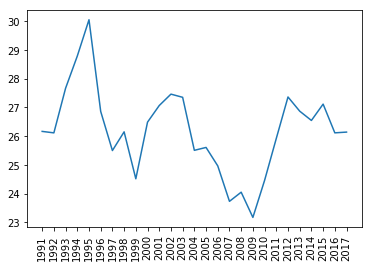

train_dataset: 21, test_dataset: 11


predicting data	: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 458.38it/s]


Train Score: 0.60 RMSE
Test Score: 0.95 RMSE


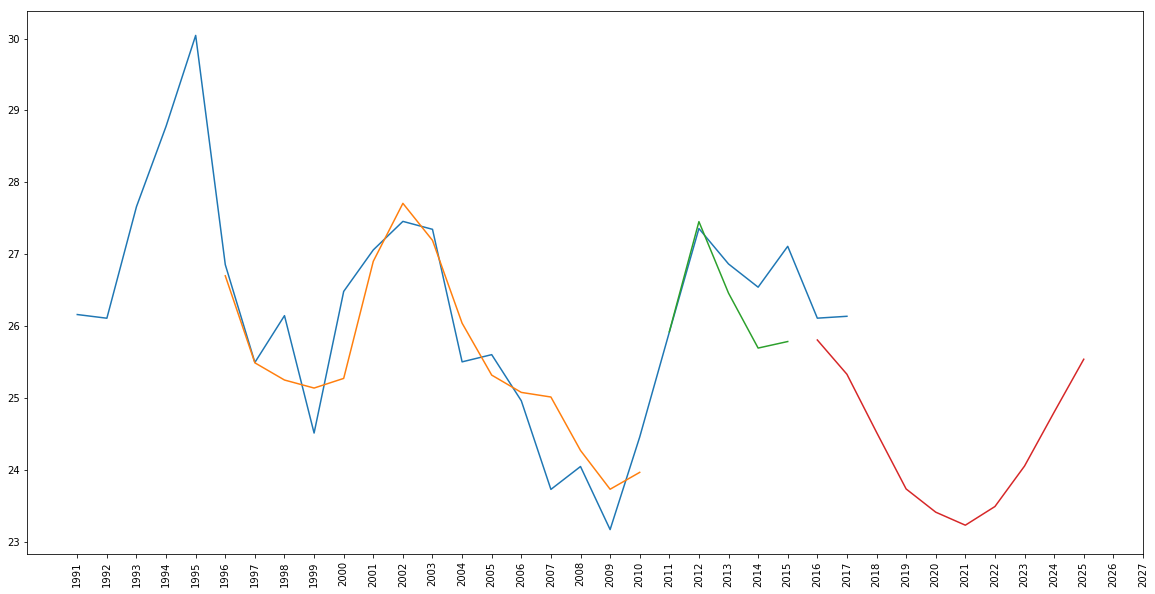

In [121]:
    datasource = 'wbdata.csv'
    dataset, scaler = load_dataset(datasource, 7)
    # split into train and test sets
    look_back = int(len(dataset) * 0.20)
    train_size = int(len(dataset) * 0.80)
    train, test = split_dataset(dataset, train_size, look_back)

    # reshape into X=t and Y=t+1
    train_x, train_y = create_dataset(train, look_back)
    test_x, test_y = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = numpy.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = numpy.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

    # create and fit Multilayer Perceptron model
    batch_size = 1
    model = build_model(look_back, batch_size=batch_size)
    for _ in trange(100, desc='fitting model\t', mininterval=1.0):
        model.fit(train_x, train_y, epochs=2, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

    # generate predictions for training
    train_predict = model.predict(train_x, batch_size)
    test_predict = model.predict(test_x, batch_size)

    # generate forecast predictions
    forecast_predict = make_forecast(model, test_x[-1::], timesteps=10, batch_size=batch_size)

    # invert dataset and predictions
    dataset = scaler.inverse_transform(dataset)
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform([train_y])
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform([test_y])
    forecast_predict = scaler.inverse_transform(forecast_predict)
    
    

    # calculate root mean squared error
    train_score = numpy.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
    print('Train Score: %.2f RMSE' % train_score)
    test_score = numpy.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
    print('Test Score: %.2f RMSE' % test_score)

    plot_data(dataset, look_back, train_predict, test_predict, forecast_predict)
    

